$\large\textbf{EXERCISE. 2 : BFGS Method}$

Recall that to solve problems of the form $\min_{\mathbf{x} \in {\mathbb{R}}^n} f(\mathbf{x})$, the update rule involved in Newton's method is of the form: 
\begin{align}
\mathbf{x}^{k+1} = \mathbf{x}^{k} - \eta^k (\nabla^2 f(\mathbf{x}^{k}))^{-1} \nabla f(\mathbf{x}^{k}).   
\end{align}

We discussed in Exercise 1 of this lab about the difficulties involved in computing the exact inverse of Hessian matrix. Now we will discuss a method which avoids explicit computation of the inverse of Hessian matrix at each iteration, but is nearly efficient as the Newton's method. This method will be called BFGS named after the famous applied Mathematicians Broyden, Fletcher, Goldfarb and Shanno. 

The main idea of BFGS method is to replace the inverse of Hessian matrix $(\nabla^2 f(\mathbf{x}^{k}))^{-1}$ in the update rule of Newton's method with a surrogate term $B^k$. 

Therefore the update rule of BFGS looks as follows:
\begin{align}
\mathbf{x}^{k+1} = \mathbf{x}^{k} - \eta^k B^k \nabla f(\mathbf{x}^{k})   
\end{align}
where $B^k$ is a surrogate for the inverse of Hessian matrix. 

To find a suitable candidate for $B^k$, we need to consider some favorable characteristics expected from $B^k$: 

\begin{align}
&B^k \text{ is symmetric positive definite}.  \\
&B^k \text{ does not involve computing Hessian or its inverse and should be computable only from the gradients}.  \\
&\text{Replacing  } (\nabla^2 f(\mathbf{x}^{k}))^{-1} \text{ with } B^k \text{ should not slow down the algorithm too much}. \\ 
\end{align}

$\large\textbf{1.[R]}$
We will choose identity matrix as initial choice of B(denoted by $B^0$).

In [2]:
import numpy as np
import pandas as pd
from timeit import default_timer as timer


In [1]:
def evalf(x,n):
  assert type(x) is np.ndarray
  assert n >=2
  assert len(x) == n
  fun = 0
  for i in range(n-1):
    fun = fun + 2*(x[i]**2 - x[i+1])**2 + (x[i]-1)**2
  return fun

In [4]:

def evalg(x,n):
  assert type(x) is np.ndarray
  assert n >=2
  assert len(x) == n
  fun1 = np.zeros(n)
  fun1[0] = 8*x[0]*(x[0]**2 - x[1]) + 2*(x[0]-1)
  for i in range(1,n-1):
    fun1[i] = -4*(x[i-1]**2 - x[i]) + 8*x[i]*(x[i]**2 - x[i+1]) + 2*(x[i]-1)
  fun1[n-1] = -4*(x[n-2]**2 - x[n-1])
  return fun1.reshape((n,1))

In [6]:
def evalh(x,n):
  assert type(x) is np.ndarray
  assert n >=2
  assert len(x) == n

  hess = np.zeros((n,n))
  hess[0][0] = 8*(x[0]**2 - x[1]) + 16*x[0]**2 + 2
  hess[0][1] = -8*x[0]

  for i in range(1,n-1):
    hess[i][i] = 4 + 16*x[i]**2 + 8*(x[i]**2 - x[i+1]) +2
    hess[i][i+1] = -8*x[i]
    hess[i][i-1] = hess[i-1][i]

  hess[n-1][n-2] = hess[n-2][n-1]
  hess[n-1][n-1] = 4

  return hess

In [5]:
def compute_steplength_backtracking_scaled_direction(x,n ,gradf, direction, alpha_start, rho, gamma): #add appropriate arguments to the function 
  assert type(x) is np.ndarray and len(gradf) == n 
  assert type(gradf) is np.ndarray and len(gradf) == n 
  assert type(direction) is np.ndarray and len(direction) == n
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 

  alpha = alpha_start
  p = -gradf

  while (evalf(x + alpha*np.matmul(direction,p),n) > (evalf(x,n) + gamma * alpha * np.matmul(gradf.T, np.matmul(direction, p))) ):
    alpha = alpha*rho
 
  return alpha

In [7]:
#line search type 
CONSTANT_STEP_LENGTH = 3
BACKTRACKING_LINE_SEARCH = 2
EXACT_LINE_SEARCH = 1

In [21]:
def find_minimizer_Newtonmethod(start_x, n, tol, line_search_type, *args):
  #Input: start_x is a numpy array of size n, tol denotes the tolerance and is a positive float value
  assert type(start_x) is np.ndarray #do not allow arbitrary type arguments 
  assert len(start_x) == n #do not allow arbitrary size arguments 
  assert type(tol) is float and tol>=0 
  
  x = start_x.reshape((n,1))
  fun1_x = evalg(x,n)
  

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])
  k = 0
  
  #print('iter:',k,  ' f(x):', evalf(x,n), ' gradient norm:', np.linalg.norm(g_x))

  while (np.linalg.norm(fun1_x) > tol):

    d = np.linalg.inv(evalh(x,n))

    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x,n,fun1_x, d , alpha_start,rho, gamma)
 
    elif line_search_type == CONSTANT_STEP_LENGTH: 
      step_length = 1.0
 
    else:  
      raise ValueError('Line search type unknown. Please check!')
 
    x = np.subtract(x, step_length * np.matmul(d,fun1_x)) 
    k = k + 1 
    fun1_x = evalg(x,n)
  
  return x, k

In [18]:


def find_minimizer_BFGS_Methods(start_x, n, tol,line_search_type,*args):
  x = start_x.reshape((n,1))
  k = 0
  fun1_new = evalg(x,n)
  B = np.identity(n)  /10

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])



  while (np.linalg.norm(fun1_new) > tol):

    d = B

    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x,n,g_new, d , alpha_start,rho, gamma)
 
    elif line_search_type == CONSTANT_STEP_LENGTH: 
      step_length = 1.0
 
    else:  
      raise ValueError('Line search type unknown. Please check!')
      
    

    fun1_old = evalg(x,n)
    
    p = np.matmul(-1*B, fun1_old)
        
    x = x + step_length * p
    s = step_length * p
    
    fun1_new = evalg(x,n)
    y = fun1_new - fun1_old
    

    mu = 1 / (np.matmul(y.T,s))
  

    term1 = np.identity(n) - mu * np.matmul(s,y.T)
    term2 = np.identity(n) - mu * np.matmul(y, s.T)

    B = np.matmul(term1, np.matmul(B ,term2))  +  mu * np.matmul(s,s.T)
    
    k = k + 1

  return x, k



In [22]:
values_n = np.array([1000,2500,5000,7500,10000])
tol = 1e-9
alpha =0.9
rho = 0.5
gamma = 0.5

time_taken_bfgs = []
time_taken_newton = []


for i in values_n:
  my_start_x = np.zeros(i)

  time_start = timer() 
  x,k = find_minimizer_BFGS_Methods(my_start_x,i,tol,CONSTANT_STEP_LENGTH)
  time_end = timer()
  time_taken_bfgs.append(time_end - time_start)

  time_start = timer() 
  x,k = find_minimizer_Newtonmethod(my_start_x,i,tol,CONSTANT_STEP_LENGTH)
  time_end = timer()
  time_taken_newton.append(time_end - time_start)
print('Time taken by newton method',time_taken_newton)
print('Time taken by BFGS method',time_taken_bfgs)






/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in multiply
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in square
  if __name__ == '__main__':
/usr/l

Time taken by newton method [1.5504095569999663, 14.661786220000067, 104.47532232399999, 356.3647456249996, 842.2226514699996]
Time taken by BFGS method [15.141176594999934, 51.78353073999983, 292.42439980100016, 918.7889135379999, 2154.483384744]


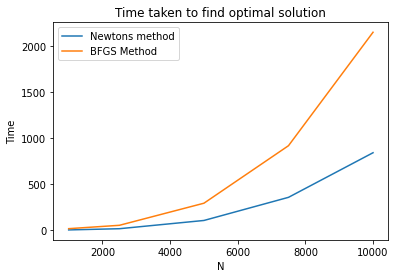

In [23]:

import matplotlib.pyplot as plt
plt.plot(values_n,time_taken_newton ,label='Newtons method')
plt.plot(values_n,time_taken_bfgs ,label='BFGS Method')
plt.title('Time taken to find optimal solution')
plt.xlabel('N')
plt.ylabel('Time')
plt.legend()
plt.show()

Here by graph we can clearly see that the time taken is greater for BFGS method than for Newton method also the values by BFGS method are not converging.

$\large\textbf{3.[R]}$ Use backtracking line search with $\alpha^0 =0.9$ , $\rho = 0.5$, $\gamma = 0.5$ in the implementation of BFGS method. Take
the starting point to be $x^0 = (0, 0, . . . , 0)$. Compare the time taken by BFGS method with backtracking linesearch against the time taken by Newton’s method for each value of n. Plot the time taken vs n using different colors. Comment on your observations

In [ ]:

values_n = np.array([1000,2500,5000,7500,10000])
tol = 1e-9
alpha =0.9
rho = 0.5
gamma = 0.5

time_taken_bfgs = []
time_taken_newton = []


for i in values_n:
  my_start_x = np.zeros(i)

  time_start = timer() 
  x,k = find_minimizer_BFGS(my_start_x,i,tol,BACKTRACKING_LINE_SEARCH,alpha,rho,gamma)
  time_end = timer()
  time_taken_bfgs.append(time_end - time_start)

  time_start = timer() 
  x,k = find_minimizer_Newtonmethod(my_start_x,i,tol,CONSTANT_STEP_LENGTH)
  time_end = timer()    
  time_taken_newton.append(time_end - time_start)
print('Time taken by newton method',time_taken_newton)
print('Time taken by BFGS method',time_taken_bfgs)
  




Time taken by newton method [1.6446732069998689, 15.774111783999615, 103.84538404200066, 326.45589514400035, 773.742142688001]
Time taken by BFGS method [9.896574317000159, 83.66151063699999, 559.4789788429998, 1808.378719028, 4198.330671792999]


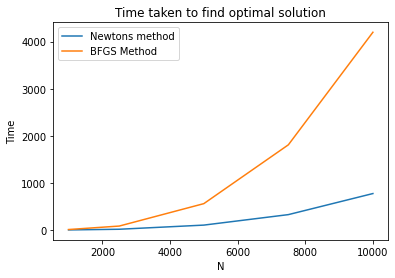

In [ ]:
plt.plot(values_n,time_taken_newton ,label='Newtons method')
plt.plot(values_n,time_taken_bfgs ,label='BFGS Method')
plt.title('Time taken to find optimal solution')
plt.xlabel('values')
plt.ylabel('Time taken')
plt.legend()
plt.show()

Comment: hence, newtons method is better then the BFGS Method of this problem.